In [26]:
from keras.datasets import cifar100
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout, Activation, Input
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from vit_keras import vit, utils

import numpy as np
import matplotlib.pyplot as plt
from itertools import chain

def get_cifar100():
    # download data
    (x_train, y_train), (x_test, y_test) = cifar100.load_data()
    return x_train, y_train, x_test, y_test

x_train, y_train,x_test,y_test = get_cifar100()

# Check 
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

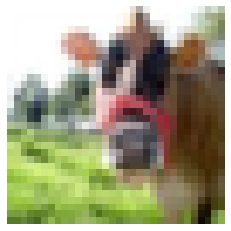

In [27]:
# vIsualization sample images
plt.figure(figsize=(4,4))
image = x_train[0]
plt.imshow(image.astype("uint8"))
plt.axis("off")
plt.show()

In [ ]:
# resize and patch the image
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)

# get number of patch width (or height)
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))

# patch the image and visualize each patch
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

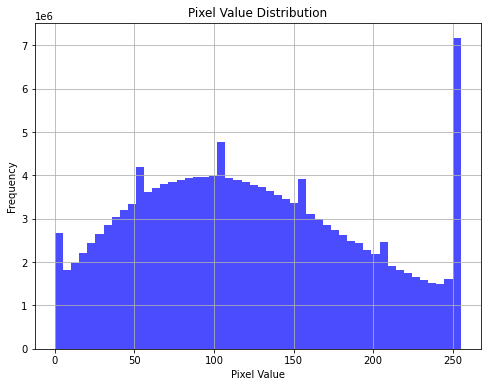

In [13]:
# check pixel distribution
plt.figure(figsize=(8, 6))
pixel_values = x_train.reshape(-1)
plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [15]:
x_train, x_validation, y_train, y_validation = train_test_split(
    x_train, y_train, test_size=0.15, random_state=42
)

num_classes = len(set(list(chain(*y_train))))
input_shape = (32,32,3)

# one-hot encoding and rescaling 
# 1~255 인 형태의 데이터를 모델 학습에 용이하도록 0~1로 변환
x_train = (x_train/255.).astype("float32")
x_validation = (x_validation/255.).astype("float32")
x_test = (x_test/255.).astype("float32")

y_train = np_utils.to_categorical(y_train, num_classes)
y_validation = np_utils.to_categorical(y_validation, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)


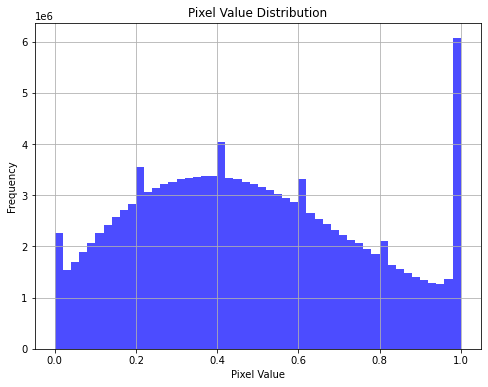

In [17]:
# check pixel distribution
plt.figure(figsize=(8, 6))
pixel_values = x_train.reshape(-1)
plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [18]:
# 기본 모델 구조 정의

input_shape = (32, 32, 3) 
image_size = 256 

def create_model():
    # set input layer
    inputs = layers.Input(shape=input_shape)
    
    # overfitting 방지하고자 더 다양한 공간정보를 호ㅘㄹ용하도록 이미지 크기 증가
    x = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (image_size, image_size)))(inputs)
    
    # opensource 활용
    base_model = vit.vit_b16(
        image_size=image_size, 
        activation="sigmoid", 
        pretrained=True,
        include_top=False, 
        pretrained_top=False
    )

    base_model.trainable = False
    x = base_model(x)
    x = Flatten()(x)
    
    # overfitting 을 방지하고자 Batch Normalization layer 추가
    x = BatchNormalization()(x)
    x = Dense(32, activation=tf.nn.gelu)(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    
    # create model
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [19]:
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="C:\\Users\\user\\crytolab_test\\base_model.keras",
    save_best_only=True,
    monitor="val_loss"
  )
]

# 데이터 증강기법으로 ImageDataGenerator 을 활용
batch_size = 32
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)

validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow(x_validation, y_validation, batch_size=batch_size)


In [6]:
# training settings
model = create_model()
model.compile(loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

num_epochs = 2

# 훈련속도를 위해 GPU 활용
with tf.device("/device:GPU:0"):
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        batch_size=128,
        epochs=num_epochs,
        callbacks=callbacks,
        verbose=1,
    )

C:\Users\user\anaconda3\envs\gpu3080\lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 16, 16
  warnings.warn(


Epoch 1/2
1329/1329 [==============================] - 285s 207ms/step - loss: 2.4255 - accuracy: 0.4269 - val_loss: 1.2337 - val_accuracy: 0.6644
Epoch 2/2
1329/1329 [==============================] - 278s 209ms/step - loss: 1.5459 - accuracy: 0.5806 - val_loss: 1.0782 - val_accuracy: 0.7003


In [9]:
# 1차 테스트 결과
test_loss, test_acc = model.evaluate(x_test,y_test,
                       batch_size=batch_size,
                       verbose=0)
print('Test loss:', test_loss)
print('Test acc:', test_acc)

Test loss: 3.848177433013916
Test acc: 0.1662999987602234


In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 하이퍼 파라미터 튜닝을 위해 ReduceLROnPlateau,EarlyStopping 사용
plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=1, verbose=1)
earlystopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)

model = create_model()

model.compile(loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
 )

with tf.device("/device:GPU:0"):

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        batch_size=256, # 배치 사이즈 조정 
        epochs=10,
        callbacks=[plateau, earlystopping],
        verbose=1
    )

C:\Users\user\anaconda3\envs\gpu3080\lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 16, 16
  warnings.warn(


Epoch 1/10
1329/1329 [==============================] - 284s 209ms/step - loss: 2.4224 - accuracy: 0.4325 - val_loss: 1.2231 - val_accuracy: 0.6651 - lr: 0.0010
Epoch 2/10
1329/1329 [==============================] - 276s 208ms/step - loss: 1.5446 - accuracy: 0.5817 - val_loss: 1.0915 - val_accuracy: 0.6943 - lr: 0.0010
Epoch 3/10
1329/1329 [==============================] - 277s 208ms/step - loss: 1.4208 - accuracy: 0.6099 - val_loss: 1.0324 - val_accuracy: 0.7061 - lr: 0.0010
Epoch 4/10
1329/1329 [==============================] - 279s 210ms/step - loss: 1.3612 - accuracy: 0.6210 - val_loss: 0.9925 - val_accuracy: 0.7175 - lr: 0.0010
Epoch 5/10
1329/1329 [==============================] - 275s 207ms/step - loss: 1.3332 - accuracy: 0.6281 - val_loss: 0.9843 - val_accuracy: 0.7189 - lr: 0.0010
Epoch 6/10
1329/1329 [==============================] - 275s 207ms/step - loss: 1.3060 - accuracy: 0.6347 - val_loss: 0.9767 - val_accuracy: 0.7183 - lr: 0.0010
Epoch 7/10
1329/1329 [============

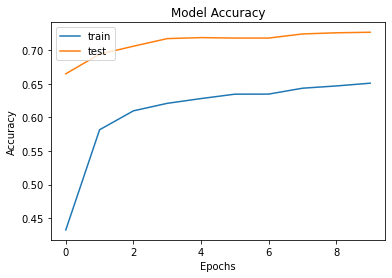

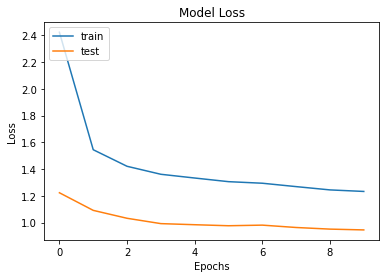

In [21]:
# check accuracy 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# check loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
model.save_weights('check_point/check_point')
model.save('save_model/my_model')


In [ ]:
# 저장된 모델 불러오기

# model = create_model()
# model.compile(loss='categorical_crossentropy',
#   optimizer='adam',
#   metrics=['accuracy']
#  )
# loss, acc = model.evaluate(x_test,y_test)
# print("Untrained model, accuracy: {:5.2f}%".format(100*acc))

# model.load_weights("check_point/check_point")
# model.compile(loss='categorical_crossentropy',
#   optimizer='adam',
#   metrics=['accuracy']
#  )
# loss, acc = model.evaluate(x_test,y_test)
# print("Restored model, accuracy: {:5.2f}%".format(100*acc))


In [38]:
import json
import numpy
from json import JSONEncoder

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

# Serialization
numpyData = {"array": x_test[0]}
encodedNumpyData = json.dumps(numpyData, cls=NumpyArrayEncoder) 

decodedArrays = json.loads(encodedNumpyData)

finalNumpyArray = numpy.asarray(decodedArrays["array"])
result=model.predict(np.expand_dims(x_train[0], axis=0))

In [24]:
result=model.predict(np.expand_dims(x_train[0], axis=0))

In [139]:
# 정답 확인용 
coarse_label = [
'apple', # id 0
'aquarium_fish',
'baby',
'bear',
'beaver',
'bed',
'bee',
'beetle',
'bicycle',
'bottle',
'bowl',
'boy',
'bridge',
'bus',
'butterfly',
'camel',
'can',
'castle',
'caterpillar',
'cattle',
'chair',
'chimpanzee',
'clock',
'cloud',
'cockroach',
'couch',
'crab',
'crocodile',
'cup',
'dinosaur',
'dolphin',
'elephant',
'flatfish',
'forest',
'fox',
'girl',
'hamster',
'house',
'kangaroo',
'computer_keyboard',
'lamp',
'lawn_mower',
'leopard',
'lion',
'lizard',
'lobster',
'man',
'maple_tree',
'motorcycle',
'mountain',
'mouse',
'mushroom',
'oak_tree',
'orange',
'orchid',
'otter',
'palm_tree',
'pear',
'pickup_truck',
'pine_tree',
'plain',
'plate',
'poppy',
'porcupine',
'possum',
'rabbit',
'raccoon',
'ray',
'road',
'rocket',
'rose',
'sea',
'seal',
'shark',
'shrew',
'skunk',
'skyscraper',
'snail',
'snake',
'spider',
'squirrel',
'streetcar',
'sunflower',
'sweet_pepper',
'table',
'tank',
'telephone',
'television',
'tiger',
'tractor',
'train',
'trout',
'tulip',
'turtle',
'wardrobe',
'whale',
'willow_tree',
'wolf',
'woman',
'worm',
]